In this file I start by implementing a compressed sensing reconstruction approach. I want to have a well accepted classical method 
as a baseline for my later deep learning models.

In [2]:
import sys
import os

sys.path.append('../scripts')
sys.path.append('../models')

os.environ["CUDA_VISIBLE_DEVICES"]= '1' #, this way I would choose GPU 3 to do the work

from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import torch
import numpy as np
import time
import h5py
import matplotlib.pyplot as plt
from scipy.ndimage import zoom # for compressing images / only for testing purposes to speed up NN training
from scipy.fft import fft2, fftshift
from scipy.io import loadmat
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn as nn
from scipy.io import savemat
import nibabel as nib
import h5py

import plotly.graph_objects as go

In [3]:
Vol = 5
brain_mask = np.load(f'Vol{Vol}/masks/brain_mask.npy')
lipid_mask = np.load(f'Vol{Vol}/masks/lipid_mask.npy')
data = np.load(f'Vol{Vol}/OriginalData/data.npy')

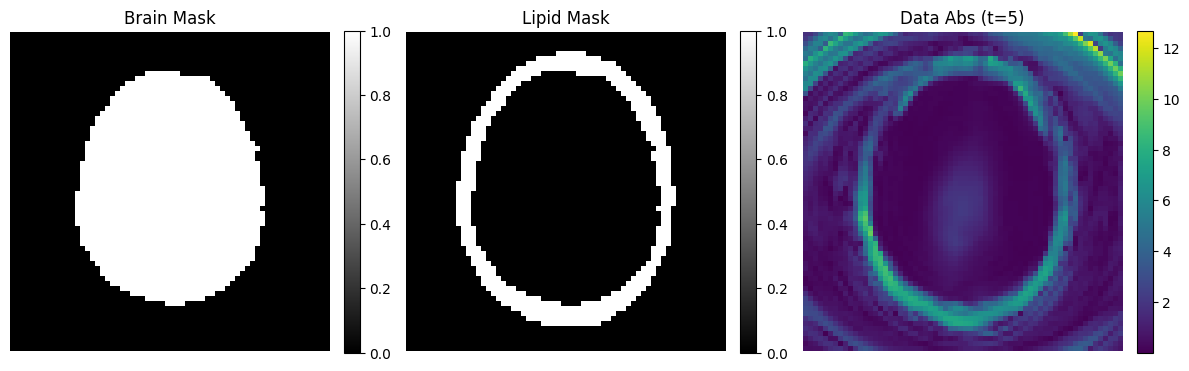

In [7]:
import matplotlib.pyplot as plt
import numpy as np

z = 17

Slice_1 = brain_mask[..., z]
Slice_2 = lipid_mask[..., z]
Slice_3 = np.abs(data[:, :, z, 5])

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

im1 = axes[0].imshow(Slice_1, cmap='gray')
axes[0].set_title("Brain Mask")
axes[0].axis('off')
fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

im2 = axes[1].imshow(Slice_2, cmap='gray')
axes[1].set_title("Lipid Mask")
axes[1].axis('off')
fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

im3 = axes[2].imshow(Slice_3, cmap='viridis')
axes[2].set_title("Data Abs (t=5)")
axes[2].axis('off')
fig.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


# Check Masks for nans and infs

In [ ]:
for Vol in range(5,10):
    brain_mask = np.load(f'Vol{Vol}/masks/brain_mask.npy')
    lipid_mask = np.load(f'Vol{Vol}/masks/lipid_mask.npy')

    print('Volume')
    print(Vol)
    print('Brainmask:')
    has_nonfinite = ~np.isfinite(brain_mask).all()
    print("Contains NaN or Inf?", has_nonfinite)  # True

    print('LipidMask:')
    has_nonfinite = ~np.isfinite(lipid_mask).all()
    print("Contains NaN or Inf?", has_nonfinite)  # True

# check original data for nans and infs

In [ ]:
for Vol in range(5,10):

    data = np.load(f'Vol{Vol}/OriginalData/data.npy')
    IsolatedWater = np.load(f'Vol{Vol}/OriginalData/IsolatedWater.npy')
    SupressedWater = np.load(f'Vol{Vol}/OriginalData/SupressedWater.npy')

    print('Volume')
    print(Vol)
    print('data:')
    has_nonfinite = ~np.isfinite(data).all()
    print("Contains NaN or Inf?", has_nonfinite)  # True

    print('IsolatedWater:')
    has_nonfinite = ~np.isfinite(IsolatedWater).all()
    print("Contains NaN or Inf?", has_nonfinite)  # True

    print('SupressedWater:')
    has_nonfinite = ~np.isfinite(SupressedWater).all()
    print("Contains NaN or Inf?", has_nonfinite)  # True

# Check Simulations for nans and infs

In [ ]:
for Vol in range(5,10):
    with h5py.File(f'Vol{Vol}/TrainData/TrainData_v_1.0.h5', 'r') as f:
        # List all top-level groups/datasets
        print('Vol', Vol)
        print("Keys:", list(f.keys()))
        lipid = f['lipid'][:]

        has_nonfinite = ~np.isfinite(lipid).all()
        print("Contains NaN or Inf?", has_nonfinite)  # True

        lipid_proj = f['lipid_proj'][:]

        has_nonfinite = ~np.isfinite(lipid_proj).all()
        print("Contains NaN or Inf?", has_nonfinite)  # True
        
        lipid_projOP = f['lipid_projOP'][:]

        has_nonfinite = ~np.isfinite(lipid_projOP).all()
        print("Contains NaN or Inf?", has_nonfinite)  # True

        metab = f['metab'][:]

        has_nonfinite = ~np.isfinite(metab).all()
        print("Contains NaN or Inf?", has_nonfinite)  # True

        spectra = f['spectra'][:]
        has_nonfinite = ~np.isfinite(spectra).all()
        print("Contains NaN or Inf?", has_nonfinite)  # True

        water = f['water'][:]
        has_nonfinite = ~np.isfinite(water).all()
        print("Contains NaN or Inf?", has_nonfinite)  # True


# Data set 9

In [ ]:
Vol = 5

brain_mask = np.load(f'Vol{Vol}/masks/brain_mask.npy')
lipid_mask = np.load(f'Vol{Vol}/masks/lipid_mask.npy')

data = np.load(f'Vol{Vol}/OriginalData/data.npy')
IsolatedWater = np.load(f'Vol{Vol}/OriginalData/IsolatedWater.npy')
SupressedWater = np.load(f'Vol{Vol}/OriginalData/SupressedWater.npy')

In [ ]:
Vol = 9
with h5py.File(f'Vol{Vol}/TrainData/TrainData_v_1.0.h5', 'r') as f:
    # List all top-level groups/datasets
    print('Vol', Vol)
    print("Keys:", list(f.keys()))
    lipid = f['lipid'][:]

    has_nonfinite = ~np.isfinite(lipid).all()
    print("Contains NaN or Inf?", has_nonfinite)  # True

    lipid_proj = f['lipid_proj'][:]

    has_nonfinite = ~np.isfinite(lipid_proj).all()
    print("Contains NaN or Inf?", has_nonfinite)  # True
    
    lipid_projOP = f['lipid_projOP'][:]

    has_nonfinite = ~np.isfinite(lipid_projOP).all()
    print("Contains NaN or Inf?", has_nonfinite)  # True

    metab = f['metab'][:]

    has_nonfinite = ~np.isfinite(metab).all()
    print("Contains NaN or Inf?", has_nonfinite)  # True

    spectra = f['spectra'][:]
    has_nonfinite = ~np.isfinite(spectra).all()
    print("Contains NaN or Inf?", has_nonfinite)  # True

    water = f['water'][:]
    has_nonfinite = ~np.isfinite(water).all()
    print("Contains NaN or Inf?", has_nonfinite)  # True

# Remove NANS

In [ ]:
Vol = '1_Brisbane_B0_corrected'

brain_mask = np.load(f'Vol{Vol}/masks/brain_mask.npy')
lipid_mask = np.load(f'Vol{Vol}/masks/lipid_mask.npy')

print('Volume')
print(Vol)
print('Brainmask:')
has_nonfinite = ~np.isfinite(brain_mask).all()
print("Contains NaN or Inf?", has_nonfinite)  # True

print('LipidMask:')
has_nonfinite = ~np.isfinite(lipid_mask).all()
print("Contains NaN or Inf?", has_nonfinite)  # True

data = np.load(f'Vol{Vol}/OriginalData/data.npy')
IsolatedWater = np.load(f'Vol{Vol}/OriginalData/IsolatedWater.npy')
SupressedWater = np.load(f'Vol{Vol}/OriginalData/SupressedWater.npy')

print('Volume')
print(Vol)
print('data:')
has_nonfinite = ~np.isfinite(data).all()
print("Contains NaN or Inf?", has_nonfinite)  # True

print('IsolatedWater:')
has_nonfinite = ~np.isfinite(IsolatedWater).all()
print("Contains NaN or Inf?", has_nonfinite)  # True

print('SupressedWater:')
has_nonfinite = ~np.isfinite(SupressedWater).all()
print("Contains NaN or Inf?", has_nonfinite)  # True

with h5py.File(f'Vol{Vol}/TrainData/TrainData_v_1.0.h5', 'r') as f:
    # List all top-level groups/datasets
    print('Vol', Vol)
    print("Keys:", list(f.keys()))
    lipid = f['lipid'][:]

    has_nonfinite = ~np.isfinite(lipid).all()
    print("Contains NaN or Inf?", has_nonfinite)  # True

    lipid_proj = f['lipid_proj'][:]

    has_nonfinite = ~np.isfinite(lipid_proj).all()
    print("Contains NaN or Inf?", has_nonfinite)  # True
    
    lipid_projOP = f['lipid_projOP'][:]

    has_nonfinite = ~np.isfinite(lipid_projOP).all()
    print("Contains NaN or Inf?", has_nonfinite)  # True

    metab = f['metab'][:]

    has_nonfinite = ~np.isfinite(metab).all()
    print("Contains NaN or Inf?", has_nonfinite)  # True

    spectra = f['spectra'][:]
    has_nonfinite = ~np.isfinite(spectra).all()
    print("Contains NaN or Inf?", has_nonfinite)  # True

    water = f['water'][:]
    has_nonfinite = ~np.isfinite(water).all()
    print("Contains NaN or Inf?", has_nonfinite)  # True

Volume
5_Brisbane
Brainmask:
Contains NaN or Inf? False
LipidMask:
Contains NaN or Inf? False
Volume
5_Brisbane
data:
Contains NaN or Inf? False
IsolatedWater:
Contains NaN or Inf? False
SupressedWater:
Contains NaN or Inf? False
Vol 5_Brisbane
Keys: ['lipid', 'lipid_proj', 'lipid_projOP', 'metab', 'spectra', 'water']
Contains NaN or Inf? False
Contains NaN or Inf? False
Contains NaN or Inf? False
Contains NaN or Inf? False
Contains NaN or Inf? False
Contains NaN or Inf? False


In [ ]:
def summarize_nans_by_first_index(arr):
    nan_mask = np.isnan(arr)
    nan_indices = np.argwhere(nan_mask)

    # Count how many times each first index (row) appears
    unique_rows, counts = np.unique(nan_indices[:, 0], return_counts=True)

    print(f"Found NaNs in {len(unique_rows)} unique rows.")
    for i, count in zip(unique_rows, counts):
        print(f"Row {i}: {count} NaNs")

summarize_nans_by_first_index(lipid_proj)  # or whichever array
summarize_nans_by_first_index(spectra)  # or whichever array
summarize_nans_by_first_index(water)  # or whichever array

In [ ]:
import numpy as np
import h5py
import os

#Vol   = '3_Brisbane'
base  = f'Vol{Vol}/TrainData'
src   = os.path.join(base, 'TrainData_v_1.0.h5')
dst   = os.path.join(base, 'TrainData_v_1.1.h5')   # <- new clean file

# ------------------------------------------------------------------
# 1) Identify corrupt rows from an already-contaminated dataset
# ------------------------------------------------------------------
with h5py.File(src, 'r') as f:
    spectra = f['spectra'][...]                 # load once, file still open
bad_rows   = np.unique(np.argwhere(~np.isfinite(spectra))[:, 0])
keep_mask  = ~np.isin(np.arange(spectra.shape[0]), bad_rows)
print(f'Bad rows  : {bad_rows.tolist()}')
print(f'Rows kept : {keep_mask.sum()} of {spectra.shape[0]}')

# Which datasets should be trimmed?
datasets_to_clean = {'lipid', 'lipid_proj', 'metab', 'spectra', 'water'}
# lipid_projOP stays as-is

# ------------------------------------------------------------------
# 2) Copy & clean in one pass
# ------------------------------------------------------------------
with h5py.File(src, 'r') as fin, h5py.File(dst, 'w') as fout:
    for k in fin.keys():
        data = fin[k][...]
        if k in datasets_to_clean:
            data = data[keep_mask]              # drop corrupt rows
        fout.create_dataset(k, data=data, compression='gzip')

print('✅  Clean file written to', dst)


# Compute average projection operator

In [ ]:
import h5py
import numpy as np

version = 'v_1.0'
subjects = [6, 7, 8, 9]  # die Vol-Nummern

operators = []
for sub in subjects:
    file_path = f'Vol{sub}/TrainData/TrainData_{version}.h5'
    with h5py.File(file_path, 'r') as f:
        operators.append(f['lipid_projOP'][:])

# Stacken und Mittelwert über das 0. Axis nehmen
lipid_projOP_avg = np.mean(np.stack(operators, axis=0), axis=0)

print("Shape lipid_projOP_avg:", lipid_projOP_avg.shape)

Now saved data sets based on average operator above

In [ ]:
# for Vol in range(5,10):

#     version = 'v_1.0'
#     in_path  = f'Vol{Vol}/TrainData/TrainData_{version}.h5'
#     out_path = f'Vol{Vol}/TrainData/TrainData_{version}_averaged.h5'

#     # --- Angenommen: lipid_projOP_avg ist schon berechnet ---
#     # z.B. aus subjects = [6,7,8,9] und
#     # lipid_projOP_avg = np.mean(np.stack(operators, axis=0), axis=0)

#     # 1) Alte Daten laden
#     with h5py.File(in_path, 'r') as f:
#         metab   = f['metab'][:]
#         water   = f['water'][:]
#         spectra = f['spectra'][:]
#         lipid   = f['lipid'][:]

#     # 2) Neuen Lipid-Projektionsanteil berechnen
#     lipid_proj_new = np.matmul(spectra, lipid_projOP_avg)

#     # 3) Alles in neue Datei schreiben
#     with h5py.File(out_path, 'w') as hf:
#         hf.create_dataset('metab',       data=metab)
#         hf.create_dataset('water',       data=water)
#         hf.create_dataset('spectra',     data=spectra)
#         hf.create_dataset('lipid',       data=lipid)
#         hf.create_dataset('lipid_proj',  data=lipid_proj_new)
#         hf.create_dataset('lipid_projOP',data=lipid_projOP_avg)

#     print(f'Neue Datei geschrieben: {out_path}')